## Importing the necessary libraries

In [1]:
#import packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams


C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Reading the dataset

In [2]:

#read the file
df = pd.read_csv('NSE-TATAGLOBAL11 (2).csv')

# looking at the first five rows of the data
print(df.head())
print('\n Shape of the data:')
print(df.shape)

# setting the index as date
df['Date'] = pd.to_datetime(df.Date,format='%d-%m-%Y')
df.index = df['Date']

         Date    Open    High     Low    Last   Close  Total Trade Quantity  \
0  08-10-2018  208.00  222.25  206.85  216.00  215.15               4642146   
1  05-10-2018  217.00  218.60  205.90  210.25  209.20               3519515   
2  04-10-2018  223.50  227.80  216.15  217.25  218.20               1728786   
3  03-10-2018  230.00  237.50  225.75  226.45  227.60               1708590   
4  01-10-2018  234.55  234.60  221.05  230.30  230.90               1534749   

   Turnover (Lacs)  
0         10062.83  
1          7407.06  
2          3815.79  
3          3960.27  
4          3486.05  

 Shape of the data:
(1235, 8)


## Scaling

In [3]:

rcParams['figure.figsize'] = 20,10

scaler = MinMaxScaler(feature_range=(0, 1))

#print the head
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2018-10-08,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146,10062.83
2018-10-05,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515,7407.06
2018-10-04,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786,3815.79
2018-10-03,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590,3960.27
2018-10-01,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749,3486.05


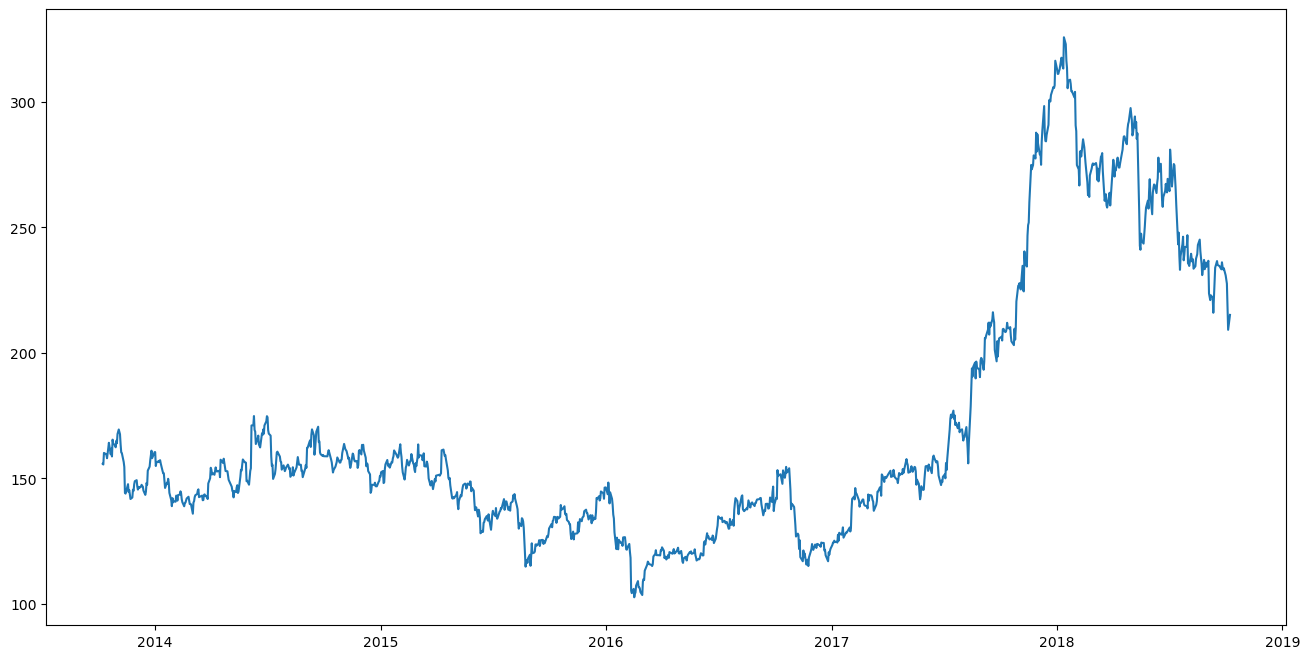

In [4]:
#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

## Train-Validation Split

In [5]:
#creating dataframe with date and the target variable
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Close'][i] = data['Close'][i]

# NOTE: While splitting the data into train and validation set, we cannot use random splitting since that will destroy the time component. So here we have set the last year’s data into validation and the 4 years’ data before that into train set.

# splitting into train and validation
train = new_data[:987]
valid = new_data[987:]

# shapes of training set
print('\n Shape of training set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)

# In the next step, we will create predictions for the validation set and check the RMSE using the actual values.
# making predictions
preds = []
for i in range(0,valid.shape[0]):
    a = train['Close'][len(train)-248+i:].sum() + sum(preds)
    b = a/248
    preds.append(b)

# checking the results (RMSE value)
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
print('\n RMSE value on validation set:')
print(rms)


 Shape of training set:
(987, 2)

 Shape of validation set:
(248, 2)

 RMSE value on validation set:
104.51415465984348


C:\Users\Pavan\AppData\Local\Temp\ipykernel_24908\753945876.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = 0
C:\Users\Pavan\AppData\Local\Temp\ipykernel_24908\753945876.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


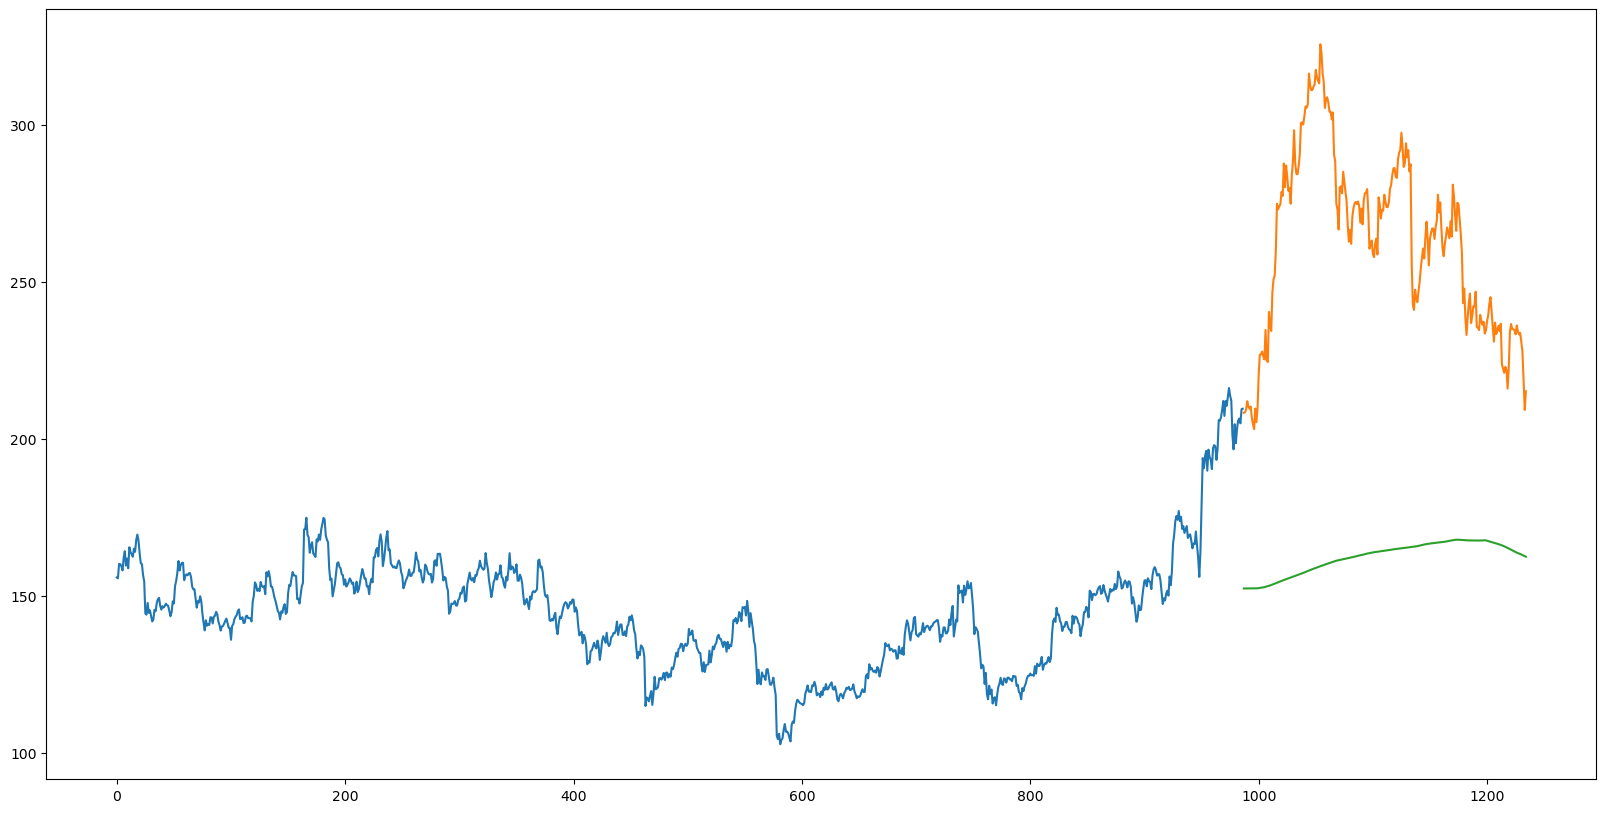

In [6]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

## LSTM

In [7]:

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

C:\Users\Pavan\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


927/927 - 18s - 19ms/step - loss: 0.0010
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


## Predictions

C:\Users\Pavan\AppData\Local\Temp\ipykernel_24908\3858486658.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


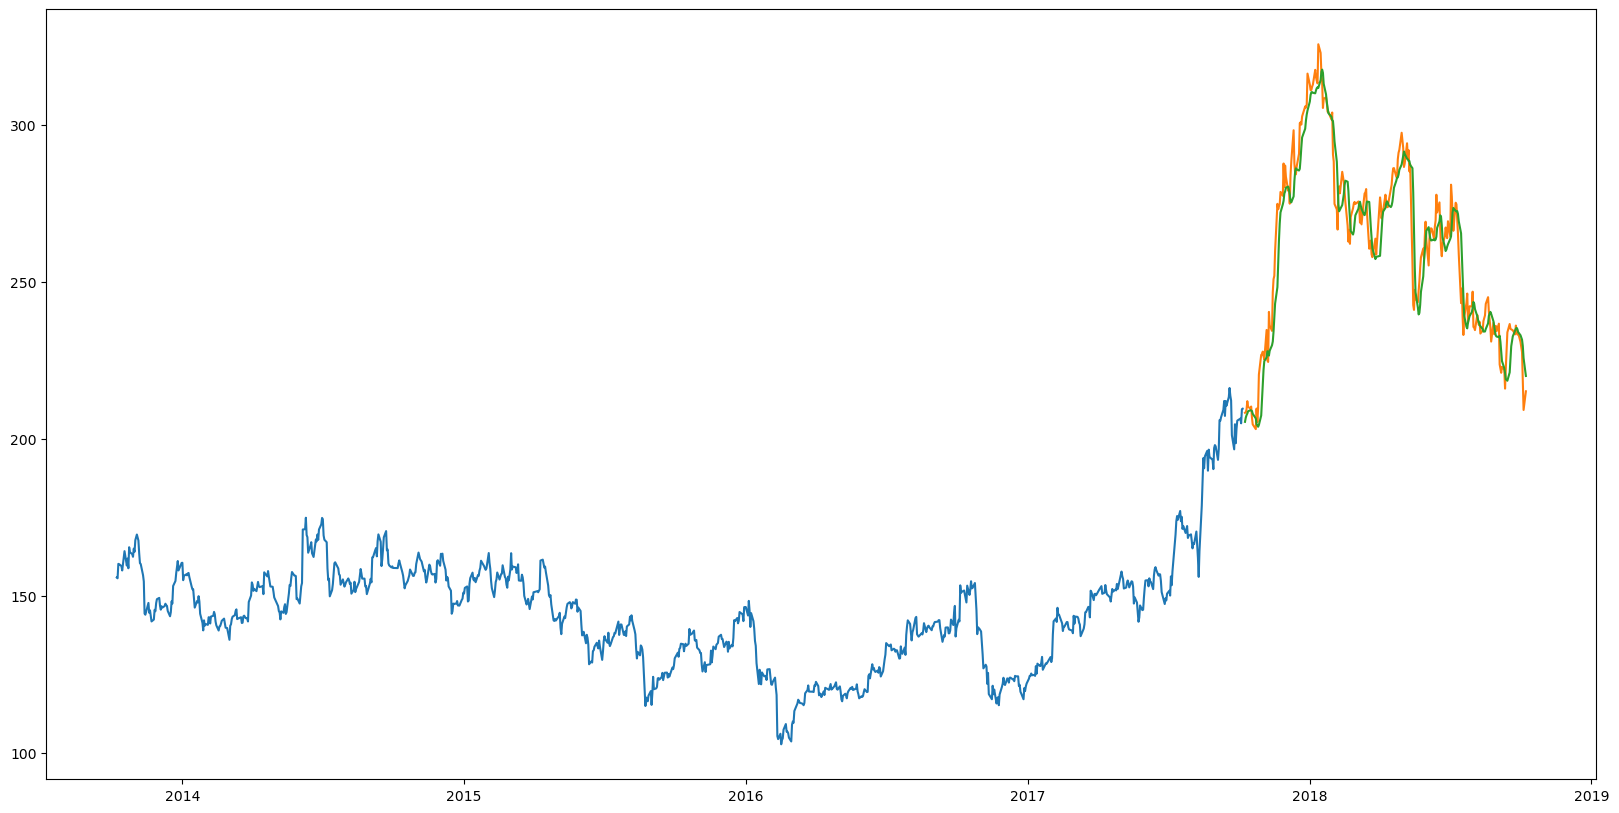

In [8]:
#for plotting
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

## Generating Future Predictions for Time Series Data

In [9]:
import pandas as pd

# Generating predictions for the next 365 days along with dates
future_dates = pd.date_range(start=new_data.index[-1], periods=366, freq='D')[1:]  # Generating dates for the next 365 days excluding today
future_predictions_with_dates = pd.DataFrame(index=future_dates, columns=['Predicted Close'])

# Generating predictions for the next 365 days
last_365_days = scaled_data[-365:]
x_future = np.reshape(last_365_days, (1, 365, 1))

for i in range(365):
    prediction = model.predict(x_future)
    future_predictions_with_dates.iloc[i]['Predicted Close'] = scaler.inverse_transform(prediction)[0][0]
    x_future = np.roll(x_future, -1, axis=1)
    x_future[0, -1, 0] = prediction[0, 0]

print(future_predictions_with_dates)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━